# Modelando os tópicos da RBEF ao longo do tempo usando Latent Dirichlet Allocation 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from multiprocessing import Pool

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from gensim.models import CoherenceModel

from utils.pre_processing import tokenizer, html_to_text
from utils.model import add_bigram, create_dictionary, create_corpus
from utils.model import ModelLDA, calc_coherence
from utils.plots import plot_frequent_words

## Leitura do banco de dados

In [3]:
df = pd.read_feather('scielo_dataset.feather')

## Tokenizaçao e Lemmetização

In [4]:
with Pool() as pool:
    # limpa o html dos textos.
    textos = list(tqdm(pool.imap(html_to_text, df['texto_html']), total=len(df)))
    
    # tokeniza e lemmetiza os textos.
    documentos = list(tqdm(pool.imap(tokenizer, textos), total=len(textos)))

  0%|          | 0/1664 [00:00<?, ?it/s]

  0%|          | 0/1664 [00:00<?, ?it/s]

## Bigram e criação do dicionário

In [5]:
add_bigram(documentos, min_count=15)

In [6]:
dicionario_sem_filtro = create_dictionary(documentos, filtrar=False)
dicionario = create_dictionary(documentos, n_abaixo=30, n_acima=0.5)

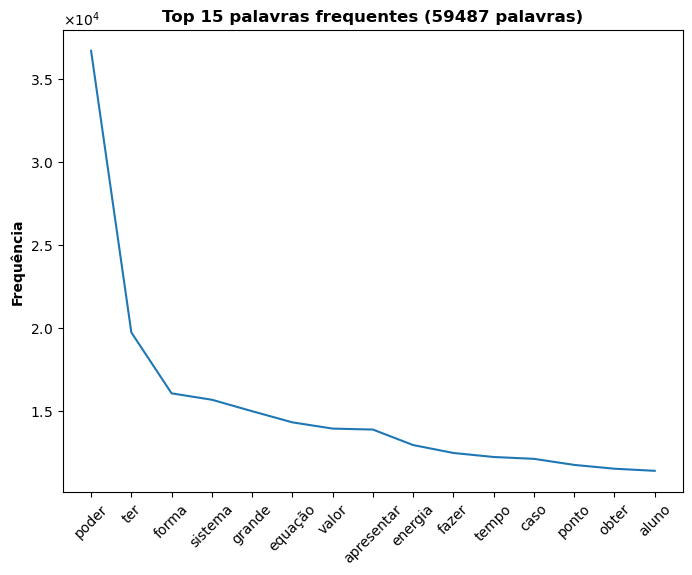

In [7]:
plot_frequent_words(dicionario_sem_filtro, filename='dicionario_completo.png')

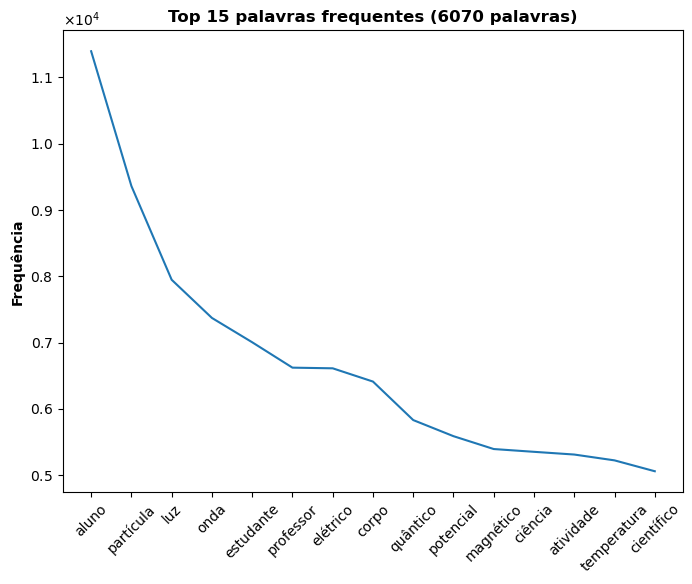

In [8]:
plot_frequent_words(dicionario, filename='dicionario_filtro.png')

In [9]:
corpus = create_corpus(dicionario, documentos, use_tfidf=False)

In [10]:
lda = ModelLDA(corpus, dicionario, chunksize=2000, iterations=400, passes=50)

# K = 12

In [11]:
model = lda.run(12)

In [40]:
df_12 = df.copy()

In [37]:
coerencia = calc_coherence(model, documentos, dicionario, corpus, method='c_v')
coerencia.get_coherence()

0.6137001539282075

In [41]:
topicos = model.get_document_topics(corpus, minimum_probability=0)
df_12['topico'] = [max(topic, key=lambda x: x[1])[0] for topic in topicos]

In [42]:
dicts_list = []
for topics in topicos:
    temp_dict = {}
    for topic, prob in topics:
        temp_dict[f"topico_{topic}"] = prob
    dicts_list.append(temp_dict)

In [43]:
df_12 = pd.concat([df_12, pd.DataFrame(dicts_list)], axis=1) 

In [44]:
pd.crosstab(df_12['nova_seção'], df_12['topico'])

topico,0,1,2,3,4,5,6,7,8,9,10,11
nova_seção,,,,,,,,,,,,
SEM CATEGORIA,0,1,2,1,1,0,1,3,1,0,3,3
artigos gerais,51,190,82,24,9,115,58,56,99,48,12,63
história da física e ciências afins,12,6,8,7,0,5,0,14,2,8,79,14
outros,2,15,6,39,5,10,8,13,2,4,31,14
pesquisa em ensino de física,9,2,11,122,37,18,21,3,1,6,4,2
produtos e materiais didáticos,25,4,18,41,9,33,47,6,2,11,3,3
seções especiais,3,10,8,10,10,4,1,1,10,2,27,13


In [61]:
n = 10  # numero de artigos
m = 15  # numero de palavras por topico
for i in df_12.topico.value_counts().keys():
    topics = model.show_topic(i, topn=m)
    palavras = ', '.join([elem[0] for elem in topics])
    temp = df_12.sort_values(by=[f'topico_{i}']).tail(n).titulo.values
    
    print(f'Tópico {i} | {df_12.topico.value_counts()[i]}')
    print('Palavras:')
    print(palavras, end='\n\n')
    print(f'{n} artigos:')
    for j, titulo in enumerate(temp, start=1):
        print(f'{j} - {titulo}')
    print('-'*100)

Tópico 3 | 244
Palavras:
aluno, professor, estudante, atividade, aula, científico, ciência, pesquisa, conteúdo, curso, didático, formação, aprendizagem, tema, disciplina

10 artigos:
1 - As leituras de textos de divulgação científica feitas por licenciandas no estágio supervisionado em física
2 - Estágio supervisionado em física: o pulso ainda pulsa...
3 - Integração curricular por áreas com extinção das disciplinas no Ensino Médio: Uma preocupante realidade não respaldada pela pesquisa em ensino de física
4 - Comunidades de Prática no Ensino de Ciências: uma revisão da literatura de 1991 a 2018
5 - Uso da Pesquisa em Ensino de Física na prática docente
6 - Simpósios, periódicos especializados, cursos de formação contínua...: qual o espaço adequado para a transferência dos resultados de pesquisa em ensino de física para o professor em exercício?
7 - Ensino de física: reflexões
8 - Por que, apesar do grande avanço da pesquisa acadêmica sobre ensino de Física no Brasil, ainda há pouca ap

In [16]:
names = ['Ensino',
'Mecânica Quântica',
'Mecânica Clássica',
'História da Ciência',
'Circuito Elétrico',
'Termodinâmica',
'Física dos Materiais',
'Física Moderna',
'Ótica',
'Eletromagnetismo',
'Astronomia',
'Metodologia']

dici = { names[i]:k for i, k in enumerate(df.topicos.value_counts().keys())}

/var/folders/sv/r3tqvm_s6jx0gsrk636pty600000gn/T/ipykernel_16277/1078811258.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,35,5), fontsize=14)
/var/folders/sv/r3tqvm_s6jx0gsrk636pty600000gn/T/ipykernel_16277/1078811258.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,35,5), fontsize=14)
/var/folders/sv/r3tqvm_s6jx0gsrk636pty600000gn/T/ipykernel_16277/1078811258.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(range(0,35,5), fontsize=14)


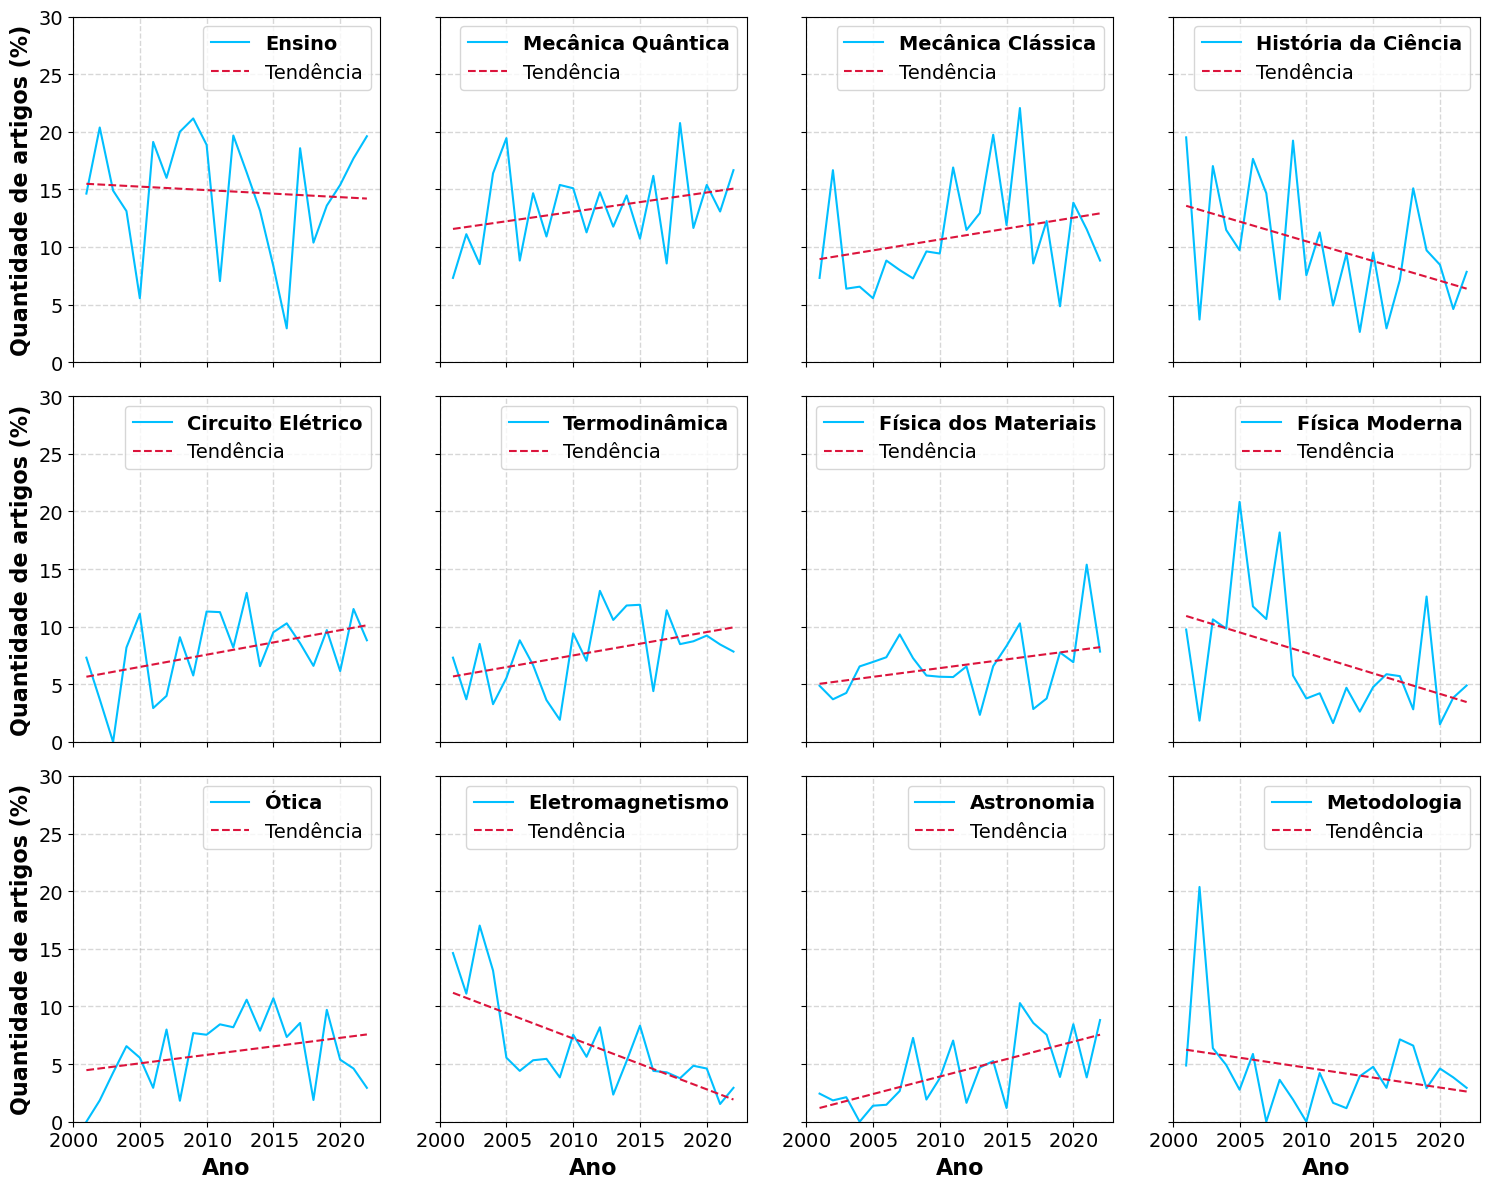

In [20]:
df_agrupado = df.pivot_table(index='ano', columns='topicos', aggfunc='size', fill_value=0)

# Calcular a soma total de frequências por ano
df_agrupado['frequencia_total'] = df_agrupado.sum(axis=1)

# Calcular a porcentagem do tópico em relação ao total no ano
df_porcentagem = df_agrupado.divide(df_agrupado['frequencia_total'], axis=0) * 100

# Se desejar, reorganize as colunas
df_porcentagem = df_porcentagem[['frequencia_total'] + list(df_agrupado.columns.drop('frequencia_total'))]

# Criar subplot 3x4
fig, axs = plt.subplots(3, 4, figsize=(15, 12))

# Iterar sobre os tópicos e plotar cada um em um subplot separado
for i, topico in enumerate(dici):
    id_ = dici[topico]
    dados_topico = df_porcentagem[id_]
    x, y = dados_topico.keys(), dados_topico.values
    fit = np.polyfit(x, y, 1)
    
    ax = axs[i // 4, i % 4]  # Determinar a posição do subplot
    ax.plot(x, y, label=f'{topico}', c='deepskyblue')
    ax.plot(x, fit[0]*x + fit[1], ls='--', label='Tendência', c='crimson')
    # ax.set_title(f'Tópico {topico+1}', weight='bold', size=15)
    ax.set_ylim([0, 30])
    ax.set_xlim([2000, 2023])
    ax.tick_params(axis='x', labelsize=14) 
    
    ax.grid(alpha=0.5, ls='--', lw=1)
    legenda = ax.legend(fontsize=14)
    legenda.get_texts()[0].set_fontweight('bold')
    
    if i >= 8:
        ax.set_xlabel('Ano', weight='bold', size=16)
    else:
        ax.xaxis.set_tick_params(labelbottom=False)
        
    if i % 4 == 0:
        ax.set_ylabel('Quantidade de artigos (%)', weight='bold', size=16)
        ax.set_yticklabels(range(0,35,5), fontsize=14)
    else:
        ax.yaxis.set_tick_params(labelleft=False)
        
    
    
# Ajustar espaçamento entre subplots
plt.tight_layout()
# Exibir o gráfico
plt.show()
fig.savefig('plots/tópicosporano.png', dpi=300, bbox_inches='tight')

# K = 9

In [62]:
model = lda.run(9)

In [63]:
df_9 = df.copy()

In [64]:
coerencia = calc_coherence(model, documentos, dicionario, corpus, method='c_v')
coerencia.get_coherence()

0.6093148683460713

In [65]:
topicos = model.get_document_topics(corpus, minimum_probability=0)
df_9['topico'] = [max(topic, key=lambda x: x[1])[0] for topic in topicos]

In [66]:
dicts_list = []
for topics in topicos:
    temp_dict = {}
    for topic, prob in topics:
        temp_dict[f"topico_{topic}"] = prob
    dicts_list.append(temp_dict)

In [67]:
df_9 = pd.concat([df_9, pd.DataFrame(dicts_list)], axis=1) 

In [68]:
pd.crosstab(df_9['nova_seção'], df_9['topico'])

topico,0,1,2,3,4,5,6,7,8
nova_seção,,,,,,,,,
SEM CATEGORIA,0,3,3,2,1,2,1,2,2
artigos gerais,51,229,96,27,11,161,65,59,108
história da física e ciências afins,14,9,8,57,0,5,29,21,12
outros,3,20,5,67,8,20,8,13,5
pesquisa em ensino de física,11,2,10,47,115,38,7,4,2
produtos e materiais didáticos,24,7,20,14,37,80,10,9,1
seções especiais,4,17,7,25,12,7,8,1,18


In [69]:
n = 10  # numero de artigos
m = 15  # numero de palavras por topico
for i in df_9.topico.value_counts().keys():
    topics = model.show_topic(i, topn=m)
    palavras = ', '.join([elem[0] for elem in topics])
    temp = df_9.sort_values(by=[f'topico_{i}']).tail(n).titulo.values
    
    print(f'Tópico {i} | {df_9.topico.value_counts()[i]}')
    print('Palavras:')
    print(palavras, end='\n\n')
    print(f'{n} artigos:')
    for j, titulo in enumerate(temp, start=1):
        print(f'{j} - {titulo}')
    print('-'*100)

Tópico 5 | 313
Palavras:
ar, gráfico, pêndulo, corpo, tensão, coeficiente, frequência, sinal, aceleração, atrito, comprimento, cm, circuito, oscilação, sensor

10 artigos:
1 - Determinação do módulo de Young em sólidos a partir da medida da velocidade do som pelo método do tempo de voo
2 - Aceleração da gravidade: Análise de experimentos didáticos
3 - O uso de 'espirais' de encadernação como molas
4 - Contadores eletrônicos no laboratório didático: Parte I. Montagem e aplicações
5 - Potência de tração de um veículo automotor que se movimenta com velocidade constante
6 - Estudo comparativo de algumas propriedades dinâmicas de líquidos e grãos na sala de aula
7 - Uma barreira vertical pode aumentar a vazão de grãos de arroz de um cilindro com furo no fundo?
8 - Bola, taco, sinuca e física
9 - As forças de atrito e os freios ABS
10 - Análise de uma corrida de 100 metros rasos
----------------------------------------------------------------------------------------------------
Tópico 1 | 28

# K = 6

In [70]:
model = lda.run(6)

In [71]:
df_6 = df.copy()

In [72]:
coerencia = calc_coherence(model, documentos, dicionario, corpus, method='c_v')
coerencia.get_coherence()

0.6118394827343173

In [73]:
topicos = model.get_document_topics(corpus, minimum_probability=0)
df_6['topico'] = [max(topic, key=lambda x: x[1])[0] for topic in topicos]

In [74]:
dicts_list = []
for topics in topicos:
    temp_dict = {}
    for topic, prob in topics:
        temp_dict[f"topico_{topic}"] = prob
    dicts_list.append(temp_dict)

In [75]:
df_6 = pd.concat([df_6, pd.DataFrame(dicts_list)], axis=1) 

In [76]:
pd.crosstab(df_6['nova_seção'], df_6['topico'])

topico,0,1,2,3,4,5
nova_seção,,,,,,
SEM CATEGORIA,2,6,3,1,1,3
artigos gerais,84,331,143,31,10,208
história da física e ciências afins,51,18,19,55,2,10
outros,10,37,12,65,6,19
pesquisa em ensino de física,14,4,12,60,105,41
produtos e materiais didáticos,29,7,25,14,38,89
seções especiais,11,22,20,28,12,6


In [77]:
n = 10  # numero de artigos
m = 15  # numero de palavras por topico
for i in df_6.topico.value_counts().keys():
    topics = model.show_topic(i, topn=m)
    palavras = ', '.join([elem[0] for elem in topics])
    temp = df_6.sort_values(by=[f'topico_{i}']).tail(n).titulo.values
    
    print(f'Tópico {i} | {df_6.topico.value_counts()[i]}')
    print('Palavras:')
    print(palavras, end='\n\n')
    print(f'{n} artigos:')
    for j, titulo in enumerate(temp, start=1):
        print(f'{j} - {titulo}')
    print('-'*100)

Tópico 1 | 425
Palavras:
partícula, quântico, potencial, carga, clássico, onda, vetor, operador, coordenada, mecânico, transformação, elétrico, parâmetro, matriz, simetria

10 artigos:
1 - O oscilador harmônico singular revisitado
2 - Solução do átomo de hidrogênio usando Supersimetria
3 - Geração de soluções exatas em Relatividade Geral através do Método de Kerr-Schild
4 - C * -Álgebras e a Descrição da Mecânica Quântica
5 - Formalismo de Hamilton-Jacobi à la Carathéodory. Parte 2: sistemas singulares
6 - Representações da Equação de Dirac em 1+1 Dimensões
7 - Princípio de ação quântica de Schwinger
8 - Método de Faddeev-Jackiw na mecânica clássica
9 - Uma introdução aos métodos de cálculo da energia de Casimir
10 - Teoria de Grupos e o Papel das Simetrias em Física
----------------------------------------------------------------------------------------------------
Tópico 5 | 376
Palavras:
corrente, elétrico, circuito, frequência, tensão, onda, magnético, ar, comprimento, sinal, fio, 

# K = 15

In [78]:
model = lda.run(15)

In [79]:
df_15 = df.copy()

In [80]:
coerencia = calc_coherence(model, documentos, dicionario, corpus, method='c_v')
coerencia.get_coherence()

0.6282876507844642

In [81]:
topicos = model.get_document_topics(corpus, minimum_probability=0)
df_15['topico'] = [max(topic, key=lambda x: x[1])[0] for topic in topicos]

In [82]:
dicts_list = []
for topics in topicos:
    temp_dict = {}
    for topic, prob in topics:
        temp_dict[f"topico_{topic}"] = prob
    dicts_list.append(temp_dict)

In [83]:
df_15 = pd.concat([df_15, pd.DataFrame(dicts_list)], axis=1) 

In [84]:
pd.crosstab(df_15['nova_seção'], df_15['topico'])

topico,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
nova_seção,,,,,,,,,,,,,,,
SEM CATEGORIA,0,3,2,3,2,0,1,1,0,0,1,2,0,0,1
artigos gerais,49,98,64,18,71,18,48,33,66,34,24,118,86,57,23
história da física e ciências afins,11,4,6,60,0,1,0,17,3,12,24,10,1,4,2
outros,2,14,7,43,7,1,8,4,0,1,6,14,5,3,34
pesquisa em ensino de física,10,2,10,10,7,1,16,2,1,3,5,1,15,1,152
produtos e materiais didáticos,26,3,15,7,5,10,38,5,0,9,0,3,32,2,47
seções especiais,4,3,9,25,1,4,0,1,13,2,2,6,6,8,15


In [86]:
n = 10  # numero de artigos
m = 15  # numero de palavras por topico
for i in df_15.topico.value_counts().keys():
    topics = model.show_topic(i, topn=m)
    palavras = ', '.join([elem[0] for elem in topics])
    temp = df_15.sort_values(by=[f'topico_{i}']).tail(n).titulo.values
    
    print(f'Tópico {i} | {df_15.topico.value_counts()[i]}')
    print('Palavras:')
    print(palavras, end='\n\n')
    print(f'{n} artigos:')
    for j, titulo in enumerate(temp, start=1):
        print(f'{j} - {titulo}')
    print('-'*100)

Tópico 14 | 274
Palavras:
aluno, estudante, professor, aula, atividade, curso, aprendizagem, conteúdo, disciplina, pesquisa, grupo, resposta, formação, didático, científico

10 artigos:
1 - As questões de física e o desempenho dos estudantes no ENEM
2 - Objetivos das aulas experimentais no ensino superior na visão de professores e estudantes da engenharia
3 - Fontes de autoeficácia e atividades experimentais de física: um estudo exploratório
4 - Simpósios, periódicos especializados, cursos de formação contínua...: qual o espaço adequado para a transferência dos resultados de pesquisa em ensino de física para o professor em exercício?
5 - Inovação didática no Ensino de Física: um estudo sobre a adoção do método Instrução pelos Colegas(Peer Instruction) no contexto de Mestrados Profissionais em Ensino no Brasil
6 - Evasão Escolar no Ensino Superior: Análise Quantitativa no Curso de Licenciatura em Física do IFPA Campus Bragança
7 - Uma revisão da literatura acerca da implementação da met